In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,LabelBinarizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB,GaussianNB
import seaborn as sns

In [7]:
cols = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship'
        ,'race','sex','capital-gain','capital-loss','hours-per-week','native-country','Salary']
adult_data = pd.read_csv('data/adult_data.csv',header=None,names=cols)
adult_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
Salary            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


As we Know that working group falls under age 18-60. Let's get it cofirm by examing this data.

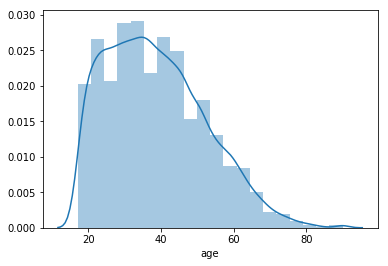

In [9]:
sns.distplot(adult_data['age'],bins=20)

Above figure shows age distribution.

Observation: Most of the data fall between 16-60.
most of the working people are at age between 20 - 45(active age)


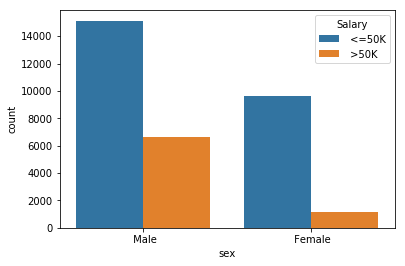

In [6]:
sns.countplot(adult_data['sex'],hue=adult_data['Salary'])

 Observation: Male Workforce is greater than Women and also Men getting more salary than women.
 

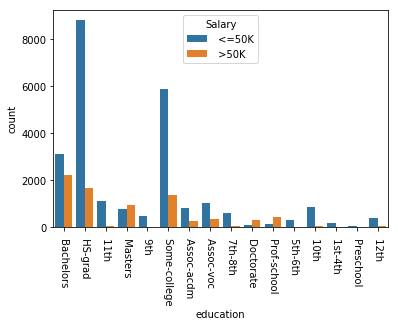

In [17]:
fig=sns.countplot(adult_data['education'],hue=adult_data['Salary'])
for item in fig.get_xticklabels():
    item.set_rotation(270)

Obseervation: Many People completed Compulsary Education(+12).

In [24]:
fig=sns.countplot(adult_data['marital-status'],hue=adult_data['Salary'],ax=ax2)
for item in fig.get_xticklabels():
    item.set_rotation(270)

Observation: Married-civ-spouses earning more salary.

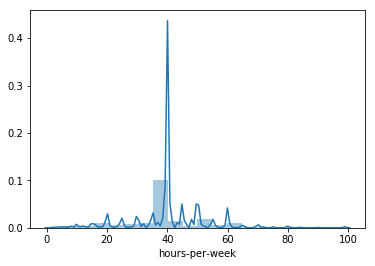

In [29]:
sns.distplot(adult_data['hours-per-week'],bins=20)


Observation: Most of the people are working about 40 hours per week.

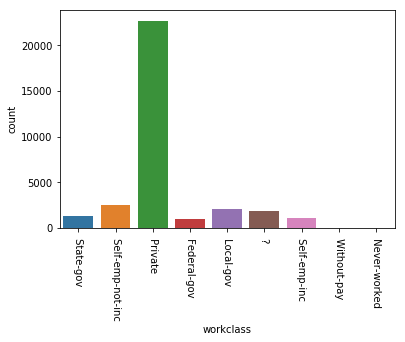

In [26]:
fig = sns.countplot(adult_data['workclass'])
for item in fig.get_xticklabels():
    item.set_rotation(270)

Observation: Private Work force is way higher than other categories. 

And also data contains unknown category (?:Missing Data)

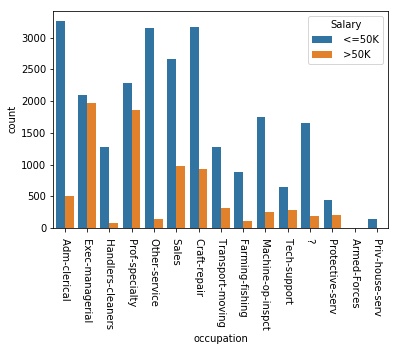

In [31]:
fig = sns.countplot(adult_data['occupation'],hue=adult_data['Salary'])
for item in fig.get_xticklabels():
    item.set_rotation(270)

Observation:Data Has Missing values.People are in managerial position earning good salary.

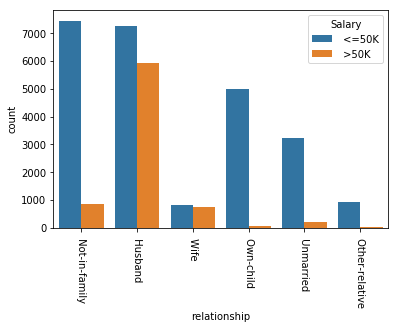

In [58]:
fig=sns.countplot(adult_data['relationship'],hue=adult_data['Salary'])
for item in fig.get_xticklabels():
    item.set_rotation(270)

Observation:Husbands getting good salary

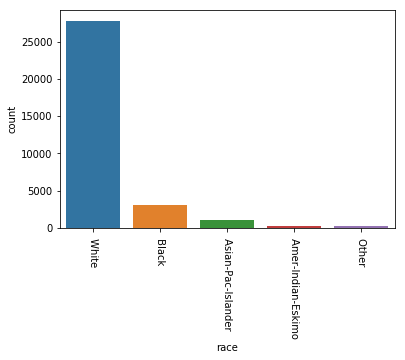

In [60]:
fig=sns.countplot(adult_data['race'])
for item in fig.get_xticklabels():
    item.set_rotation(270)

Observation :Most of the data is belongs to White. Imbalanced Data.

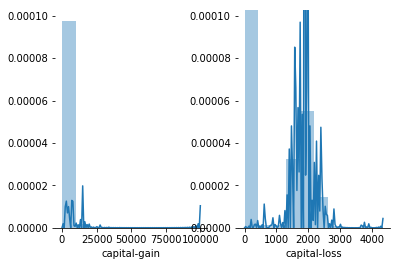

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.despine(left=True)
sns.distplot(adult_data['capital-gain'],bins=10,ax=ax1)
sns.distplot(adult_data['capital-loss'],bins=10,ax=ax2)

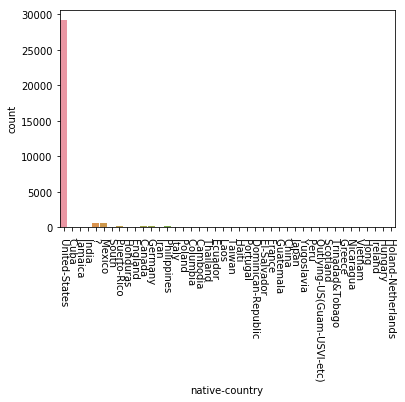

In [64]:
fig = sns.countplot(adult_data['native-country'])
for item in fig.get_xticklabels():
    item.set_rotation(270)

Observation:Most of the data belongs to USA citizens.

# Missing Value Handling

In [17]:
adult_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Salary            0
dtype: int64

Dataset doesn't have nan values. But in this Dataset missing values are encoded with special charecter '?' so we need to deal with these values.

Here I am gonna find out what is the percentage  missing values in data wrt to size of the feature.

In [18]:
columns = adult_data.columns.tolist()
num_miss = 0
miss_map ={}
for col in columns:
    if adult_data[col].dtype == 'object':
        num_miss = (adult_data[col].str.find('?')==1).sum()
        miss_map[col] = (num_miss/len(adult_data[col]))*100
print(miss_map)

{'workclass': 5.6386474616872944, 'education': 0.0, 'marital-status': 0.0, 'occupation': 5.6601455729246641, 'relationship': 0.0, 'race': 0.0, 'sex': 0.0, 'native-country': 1.7904855501980899, 'Salary': 0.0}


So many classes preset in feature. Now our goal is to reduce them to sum good figure. 
since 12-years is conpulsory education in America, we suppose that people with unfinished compulsory education most are earning lower salary.So grouping the classes from preschool to 12th.
since education-num is not providing much info going to drop it from dataset.

In [207]:
adult_data.drop('education-num',axis=1,inplace=True)

In [19]:
adult_data=adult_data.replace({'education':{' Preschool': ' Un-Finished' ,' 1st-4th':'Un-Finished',
                                 ' 5th-6th':'Un-Finished',' 7th-8th':'Un-Finished',
                                 ' 9th':'Un-Finished',' 10th':'Un-Finished',' 11th': 'Un-Finished' }})
adult_data.education.value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
Un-Finished       3769
 Masters          1723
 Assoc-voc        1382
 Assoc-acdm       1067
 Prof-school       576
 12th              433
 Doctorate         413
 Un-Finished        51
Name: education, dtype: int64

In [20]:
adult_data = adult_data.replace({'marital-status':{' Married-civ-spouse':'Married',
                                                   ' Never-married':'Single',' Divorced':'Married-Single',
                                                   ' Separated':'Married-Single',' Widowed':'Married-Single',
                                                  ' Married-spouse-absent':'Married-Single',' Married-AF-spouse':'Married'}})

In [21]:
adult_data['marital-status'].value_counts()

Married           14999
Single            10683
Married-Single     6879
Name: marital-status, dtype: int64

In [22]:
miss_value_cols = ['workclass','occupation','native-country']
for col in miss_value_cols:
    adult_data = adult_data[adult_data[col] != ' ?' ]

In [23]:
#Values in ategorical features
columns = adult_data.columns.tolist()
for col in columns:
    if adult_data[col].dtype == 'object':
        print('Feature Name:',col)
        print(adult_data[col].value_counts())
        print('_____________________________')

Feature Name: workclass
 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64
_____________________________
Feature Name: education
 HS-grad         9840
 Some-college    6678
 Bachelors       5044
Un-Finished      3319
 Masters         1627
 Assoc-voc       1307
 Assoc-acdm      1008
 Prof-school      542
 12th             377
 Doctorate        375
 Un-Finished       45
Name: education, dtype: int64
_____________________________
Feature Name: marital-status
Married           14086
Single             9726
Married-Single     6350
Name: marital-status, dtype: int64
_____________________________
Feature Name: occupation
 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving    

In [24]:
adult_data=adult_data[adult_data['native-country'] !=' Holand-Netherlands']

In [25]:
features_int = adult_data.select_dtypes(include=[np.int64]).columns
for col in features_int:
    adult_data[col] = adult_data[col].astype(np.float64)

In [26]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30161 entries, 0 to 32560
Data columns (total 15 columns):
age               30161 non-null float64
workclass         30161 non-null object
fnlwgt            30161 non-null float64
education         30161 non-null object
education-num     30161 non-null float64
marital-status    30161 non-null object
occupation        30161 non-null object
relationship      30161 non-null object
race              30161 non-null object
sex               30161 non-null object
capital-gain      30161 non-null float64
capital-loss      30161 non-null float64
hours-per-week    30161 non-null float64
native-country    30161 non-null object
Salary            30161 non-null object
dtypes: float64(6), object(9)
memory usage: 3.7+ MB


In [27]:
feature_data = adult_data.iloc[:,:-1]
target_data  = adult_data.iloc[:,-1]

In [28]:
lblEnc = LabelEncoder()
target_data_trans=lblEnc.fit_transform(target_data)

In [29]:
Xtrain,Xtest,ytrain,ytest = train_test_split(feature_data,target_data_trans,test_size=0.33,random_state=3)

In [30]:
no_action = list(set(feature_data.columns.tolist()) - set(['workclass',
                                                           'education', 'marital-status', 'occupation', 'relationship', 
                                                           'race', 'sex', 'native-country']))

In [31]:
no_action_f = no_action_f = list(map(lambda x:(x,None),no_action))

In [33]:
#apply LabelBinarizer for [LabelEncoding+OneHotEncoding]
# Data Preprocessing
mapper = DataFrameMapper([*no_action_f,
                         ('workclass',LabelBinarizer()),
                         ('education',LabelBinarizer()),
                         ('marital-status',LabelBinarizer()),
                         ('occupation',LabelBinarizer()),
                         ('relationship',LabelBinarizer()),
                         ('race',LabelBinarizer()),
                         ('sex',LabelEncoder()),
                         ('native-country',LabelBinarizer())])
#mapper2 = DataFrameMapper([*no_action_f,
                         #('workclass',OneHotEncoder()),
                         # ('education',OneHotEncoder()),
                         # ('marital-status',OneHotEncoder()),
                         # ('occupation',OneHotEncoder()),
                         #('relationship',OneHotEncoder()),
                          #('race',OneHotEncoder()),
                         # ('sex',None),
                         #('native-country',OneHotEncoder())])

In [34]:
pipeline = Pipeline([('mapper',mapper),
                     ('stdScaler',StandardScaler()),
                    ('select',SelectKBest()),
                    ('lr_cls',LogisticRegressionCV())])

In [35]:
#Object Name  given in Pipeline__ parameter which we want to tune(select__k)
parameters = {'select__k':list(np.arange(5,11))}

In [36]:
grid = GridSearchCV(pipeline,param_grid=parameters,cv=5,scoring='accuracy')

In [37]:
ytrain.shape

(20207,)

In [38]:
grid.fit(Xtrain,ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('hours-per-week', None), ('age', None), ('capital-gain', None), ('education-num', None), ('fnlwgt', None), ('capital-loss', None), ('workclass', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('educati...2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'select__k': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [39]:
grid.score(Xtest,ytest)

0.8395619851316054

In [40]:
grid.best_params_

{'select__k': 10}